In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import numpy as np
import pandas as pd
import pdb

import sys
sys.path.append('../')
from testWN import testWN as twm

from tensorflow import keras

In [15]:
%matplotlib notebook

# Get network informations

In [2]:
inp_file = '../../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [9]:
cluster_labels = pd.read_json('cluster_labels.json')
n_clusters = 30

Get results:

In [10]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions

In [11]:
jun_cl_press = results.node['pressure'][node_names[2]].groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


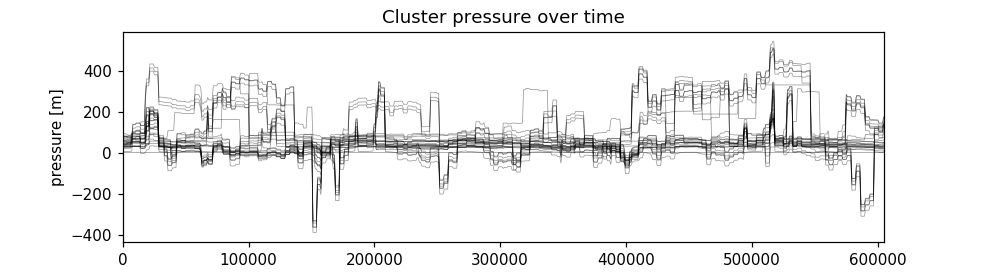

In [25]:
fig, ax = plt.subplots(figsize=(9,2.5))
jun_cl_press_mean.plot(ax=ax, legend=False, linewidth=0.5, color='k', alpha=0.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('pressure [m]')
ax.set_title('Cluster pressure over time')
plt.show()

### Tanks

In [26]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


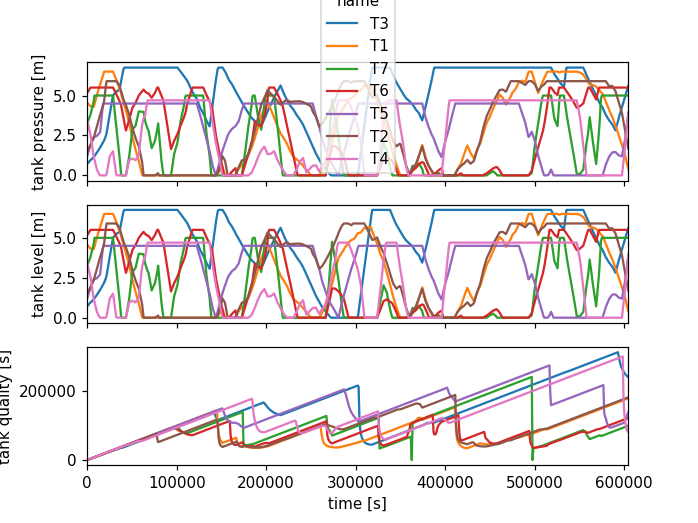

Text(0.5, 0, 'time [s]')

In [34]:
fig, ax = plt.subplots(3,1, sharex=True,)
tank_press.plot(ax=ax[0])
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
tank_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('tank quality [s]')
ax[2].set_xlabel('time [s]')

### Reservoirs

In [35]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


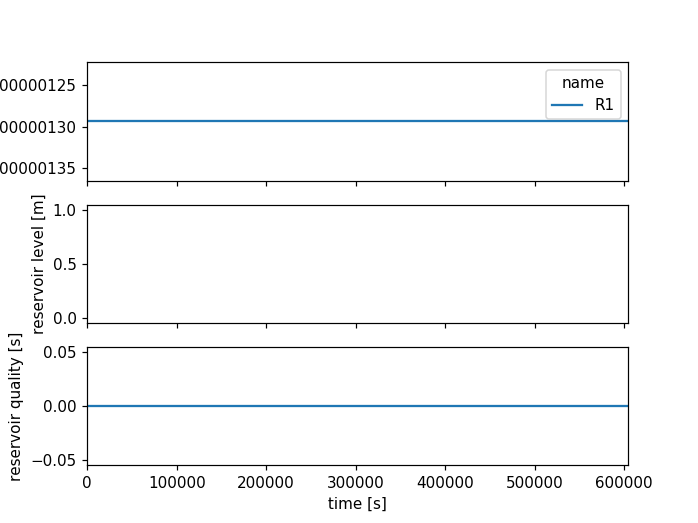

Text(0.5, 0, 'time [s]')

In [36]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [37]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

<IPython.core.display.Javascript object>


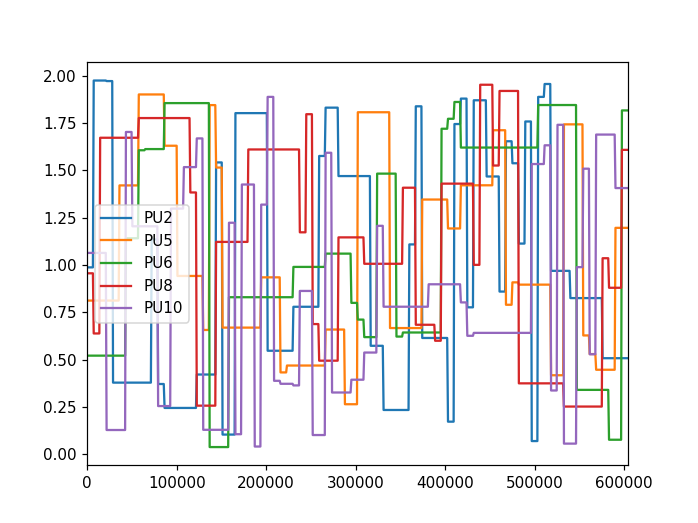

In [38]:
fig, ax = plt.subplots()
head_pump_speed.plot(ax=ax)

### Valves

In [39]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


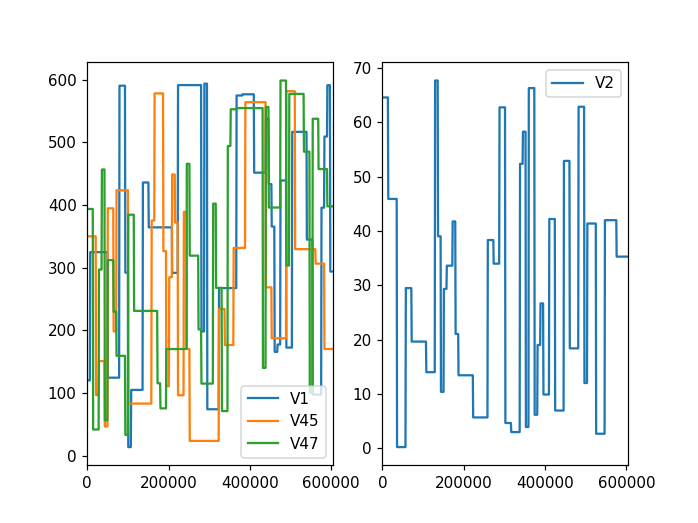

In [40]:
fig, ax = plt.subplots(1,2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [41]:
state_dict = {'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              # 'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

In [43]:
sys_inputs

head_pump_speed                                          PRValve_dp  \
pressure             PU2       PU5       PU6       PU8      PU10          V1   
0               0.987362  0.811721  0.520388  0.955995  1.063807  120.029099   
900             0.987362  0.811721  0.520388  0.955995  1.063807  120.029099   
1800            0.987362  0.811721  0.520388  0.955995  1.063807  120.029099   
2700            0.987362  0.811721  0.520388  0.955995  1.063807  120.029099   
3600            0.987362  0.811721  0.520388  0.955995  1.063807  120.029099   
...                  ...       ...       ...       ...       ...         ...   
601200          0.506876  1.196445  1.817538  1.608976  1.406902  293.807587   
602100          0.506876  1.196445  1.817538  1.608976  1.406902  293.807587   
603000          0.506876  1.196445  1.817538  1.608976  1.406902  293.807587   
603900          0.506876  1.196445  1.817538  1.608976  1.406902  293.807587   
604800          0.506876  1.196445  1.817538  1.608976  1.406902  293.807587   

                                TCValve_throttle jun_cl_demand_sum  ...  \
pressure         V45        V47               V2                 0  ...   
0         349.965057  393.62381        64.553787          0.014709  ...   
900       349.965057  393.62381        64.553787          0.014709  ...   
1800      349.965057  393.62381        64.553787          0.014709  ...   
2700      349.965057  393.62381        64.553787          0.014709  ...   
3600      349.965057  393.62381        64.553787          0.021958  ...   
...              ...        ...              ...               ...  ...   
601200    170.071579  397.89920        35.274395          0.027348  ...   
602100    170.071579  397.89920        35.274395          0.027348  ...   
603000    170.071579  397.89920        35.274395          0.027348  ...   
603900    170.071579  397.89920        35.274395          0.027348  ...   
604800    170.071579  397.89920        35.274395          0.014709  ...   

                                                                           \
pressure        20        21        22        23        24   25        26   
0         0.003068  0.000492  0.000802  0.002780  0.000641  0.0  0.000847   
900       0.003068  0.000492  0.000802  0.002780  0.000641  0.0  0.000847   
1800      0.003068  0.000492  0.000802  0.002780  0.000641  0.0  0.000847   
2700      0.003068  0.000492  0.000802  0.002780  0.000641  0.0  0.000847   
3600      0.003184  0.000690  0.000832  0.004150  0.000666  0.0  0.000324   
...            ...       ...       ...       ...       ...  ...       ...   
601200    0.004333  0.000724  0.001133  0.005169  0.000906  0.0  0.001097   
602100    0.004333  0.000724  0.001133  0.005169  0.000906  0.0  0.001097   
603000    0.004333  0.000724  0.001133  0.005169  0.000906  0.0  0.001097   
603900    0.004333  0.000724  0.001133  0.005169  0.000906  0.0  0.001097   
604800    0.003068  0.000492  0.000802  0.002780  0.000641  0.0  0.000847   

                                        
pressure        27        28        29  
0         0.000678  0.001872  0.000213  
900       0.000678  0.001872  0.000213  
1800      0.000678  0.001872  0.000213  
2700      0.000678  0.001872  0.000213  
3600      0.000704  0.000716  0.000082  
...            ...       ...       ...  
601200    0.000958  0.002425  0.000276  
602100    0.000958  0.002425  0.000276  
603000    0.000958  0.002425  0.000276  
603900    0.000958  0.002425  0.000276  
604800    0.000678  0.001872  0.000213  

[673 rows x 39 columns]

### Neural Network I/O

In [49]:
dstates = sys_states.diff(axis=0)
dstates.head(3)

jun_cl_press_mean                                                    \
pressure                0         1         2         3         4         5    
0                      NaN       NaN       NaN       NaN       NaN       NaN   
900              -0.228329 -0.034019  0.096329 -0.033501 -0.034634  0.127823   
1800             -0.226669 -0.033333  0.096008 -0.032776 -0.033928  0.127094   

                                                  ...                      \
pressure        6         7         8         9   ...        20        21   
0              NaN       NaN       NaN       NaN  ...       NaN       NaN   
900      -0.041107 -0.228027  0.135551  0.064064  ...  0.093063  0.090691   
1800     -0.040535 -0.227829  0.135151  0.064003  ...  0.092842  0.090500   

                                                                      \
pressure        22        23        24        25        26        27   
0              NaN       NaN       NaN       NaN       NaN       NaN   
900       0.135722 -0.231819  0.133060 -0.000014 -0.053881  0.134560   
1800      0.134885 -0.229843  0.132263 -0.000014 -0.053253  0.133743   

                              
pressure        28        29  
0              NaN       NaN  
900      -0.040321 -0.027668  
1800     -0.039742 -0.027096  

[3 rows x 30 columns]

In [51]:
dstates_next = dstates.shift(-1, axis=0)
dstates_next.head(3)

jun_cl_press_mean                                                    \
pressure                0         1         2         3         4         5    
0                -0.228329 -0.034019  0.096329 -0.033501 -0.034634  0.127823   
900              -0.226669 -0.033333  0.096008 -0.032776 -0.033928  0.127094   
1800             -0.218586 -0.032860  0.095673 -0.032310 -0.033455  0.126362   

                                                  ...                      \
pressure        6         7         8         9   ...        20        21   
0        -0.041107 -0.228027  0.135551  0.064064  ...  0.093063  0.090691   
900      -0.040535 -0.227829  0.135151  0.064003  ...  0.092842  0.090500   
1800     -0.040054 -0.224323  0.134754  0.063797  ...  0.092602  0.090294   

                                                                      \
pressure        22        23        24        25        26        27   
0         0.135722 -0.231819  0.133060 -0.000014 -0.053881  0.134560   
900       0.134885 -0.229843  0.132263 -0.000014 -0.053253  0.133743   
1800      0.134062 -0.233116  0.131470 -0.000014 -0.052629  0.132912   

                              
pressure        28        29  
0        -0.040321 -0.027668  
900      -0.039742 -0.027096  
1800     -0.039253 -0.026720  

[3 rows x 30 columns]

In [88]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 69)


NARX model structure?

In [89]:
if True:
    n_arx = 3
    arx_input = []
    for i in range(n_arx):
        arx_input.append(nn_input.shift(i, axis=0))

    arx_input = pd.concat(arx_input, axis=1)
    nn_input = arx_input
print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 207)


In [90]:
nn_input['sys_states', 'jun_cl_press_mean',0].head(3)

sys_states                      
         jun_cl_press_mean                      
pressure                 0          0          0
0                56.202686        NaN        NaN
900              55.974358  56.202686        NaN
1800             55.747688  55.974358  56.202686

In [91]:
nn_output = dstates_next

Filter inputs and outputs:

In [92]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (670, 207)


In [93]:
nn_input['sys_states', 'jun_cl_press_mean',0].head(3)

sys_states                      
         jun_cl_press_mean                      
pressure                 0          0          0
1800             55.747688  55.974358  56.202686
2700             55.529102  55.747688  55.974358
3600             51.342216  55.529102  55.747688

In [94]:
pd.DataFrame(nn_output['jun_cl_press_mean',0]).head(3)

,jun_cl_press_mean
,0
1800,-0.218586
2700,-4.186886
3600,-0.340122


In [95]:
nn_input['sys_states', 'jun_cl_press_mean',0].diff().head(3)

sys_states                    
         jun_cl_press_mean                    
pressure                 0         0         0
1800                   NaN       NaN       NaN
2700             -0.218586 -0.226669 -0.228329
3600             -4.186886 -0.218586 -0.226669

### Scaling

In [96]:
input_scaling = nn_input.max()
nn_input_scaled = nn_input/input_scaling

output_scaling = nn_output.max()
nn_output_scaled = nn_output/output_scaling